In [1]:
%pip install -q -e '..'

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import random


from fused_kalman_localization.PredictorProvider import UnscentedPredictorProvider
from fused_kalman_localization.CorrectorProvider import LinearCorrectorProvider, UnscentedCorrectorProvider 

# %matplotlib widget
from matplotlib import rc
rc('animation', html='html5')


In [3]:
k = 10
m = 1

omega = np.sqrt(k / m)


DELTA_T = 1e-2
times = np.arange(0, 20, DELTA_T)

amp = 1.0
true_states = np.vstack([amp * np.cos(times * omega), -amp * omega * np.sin(times * omega), k / m * np.ones(len(times))])
true_accels = np.vstack([-amp * omega**2 * np.cos(times * omega)]) 


In [4]:

class UnscentedStatePredictor(UnscentedPredictorProvider):
    def point_prop(self, state, dt):
        pos = state[0]
        vel = state[1]
        k_div_m = state[2]

        accel = -k_div_m * pos
        
        pos_prime = pos + vel * dt + accel * dt**2 / 2
        vel_prime = vel + accel * dt

        return np.array([pos_prime, vel_prime, k_div_m])

class LinearPosCorrector(LinearCorrectorProvider):
    def linear_obs_mat(self, state):
        return np.array([[1, 0, 0]])

class UnscentedAccelCorrector(UnscentedCorrectorProvider):
    def obs_pred(self, state):
        return -state[0:1, :] * state[2:3, :]

# process_noise = 1e-5 * np.eye(3)


process_noise = np.array([[1e-5, 0, 0]
                         ,[0, 1e-5, 0]
                         ,[0, 0, 9e-2]])

measurement_noise = 1e-2
a_measurement_noise = 1e-2

NUM_STATES = 3

state_predictor = UnscentedStatePredictor(process_noise, 0.0, num_states=NUM_STATES)
pos_corrector = LinearPosCorrector(measurement_noise, 0.0)
accel_corrector = UnscentedAccelCorrector(a_measurement_noise, 0.0, num_states=NUM_STATES)



pos_measurements = np.array([[1, 0, 0]]) @ true_states + np.sqrt(measurement_noise) * np.random.randn(len(times))
accel_measurements = np.array([[1]]) @ true_accels + np.sqrt(a_measurement_noise) * np.random.randn(len(times))



In [5]:
accel_corrector.obs_pred(true_states)


array([[-10.        ,  -9.99500042,  -9.98000667, ...,  -9.49602246,
         -9.39216742,  -9.27892099]], shape=(1, 2000))

In [6]:
pos_measurements.shape


(1, 2000)

In [7]:
accel_measurements.shape


(1, 2000)

## True Data Stuff

In [8]:
true_states_cov = np.cov(true_states)
print(true_states_cov)


[[ 5.03160333e-01 -3.72474993e-03  0.00000000e+00]
 [-3.72474993e-03  4.97297712e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]


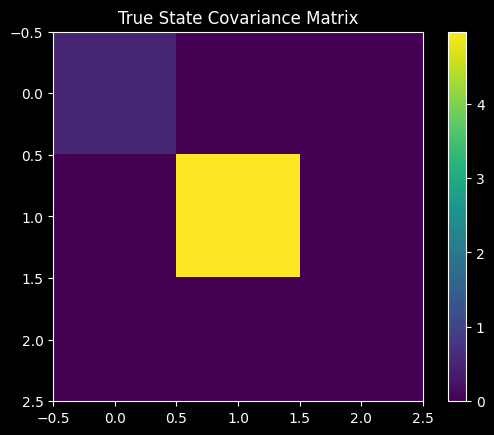

In [9]:
plt.imshow(true_states_cov, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('True State Covariance Matrix')
plt.show()


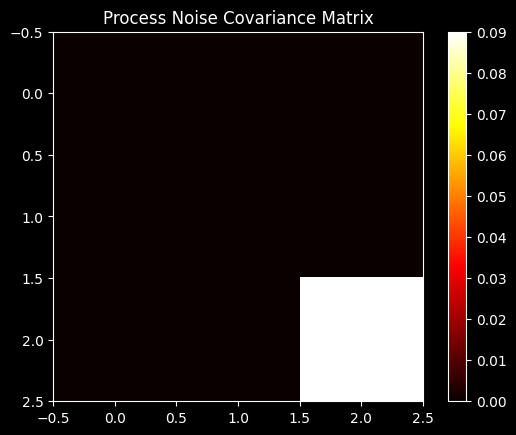

In [10]:
plt.imshow(process_noise, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Process Noise Covariance Matrix')
plt.show()


In [11]:
pos_measurements.shape


(1, 2000)

## Running the filter

In [12]:
starting_state = np.array([0.0, 0.0, 5.0])

state_history = np.zeros((3, len(times)))
cov_history = np.zeros((3, 3, len(times)))

state = starting_state
cov = (true_states_cov + true_states_cov.T) / 2
cov += 1e-5 * np.eye(NUM_STATES)
cov[2, 2] = 5.0

for ind, t in enumerate(times):
    state, cov = state_predictor.predict(state, cov, DELTA_T)

    if random.randint(0, 9) == 9:
        state, cov = pos_corrector.correct(state, cov, pos_measurements[:, ind], state_predictor)

    state_history[:, ind] = state
    cov_history[:, :, ind] = cov



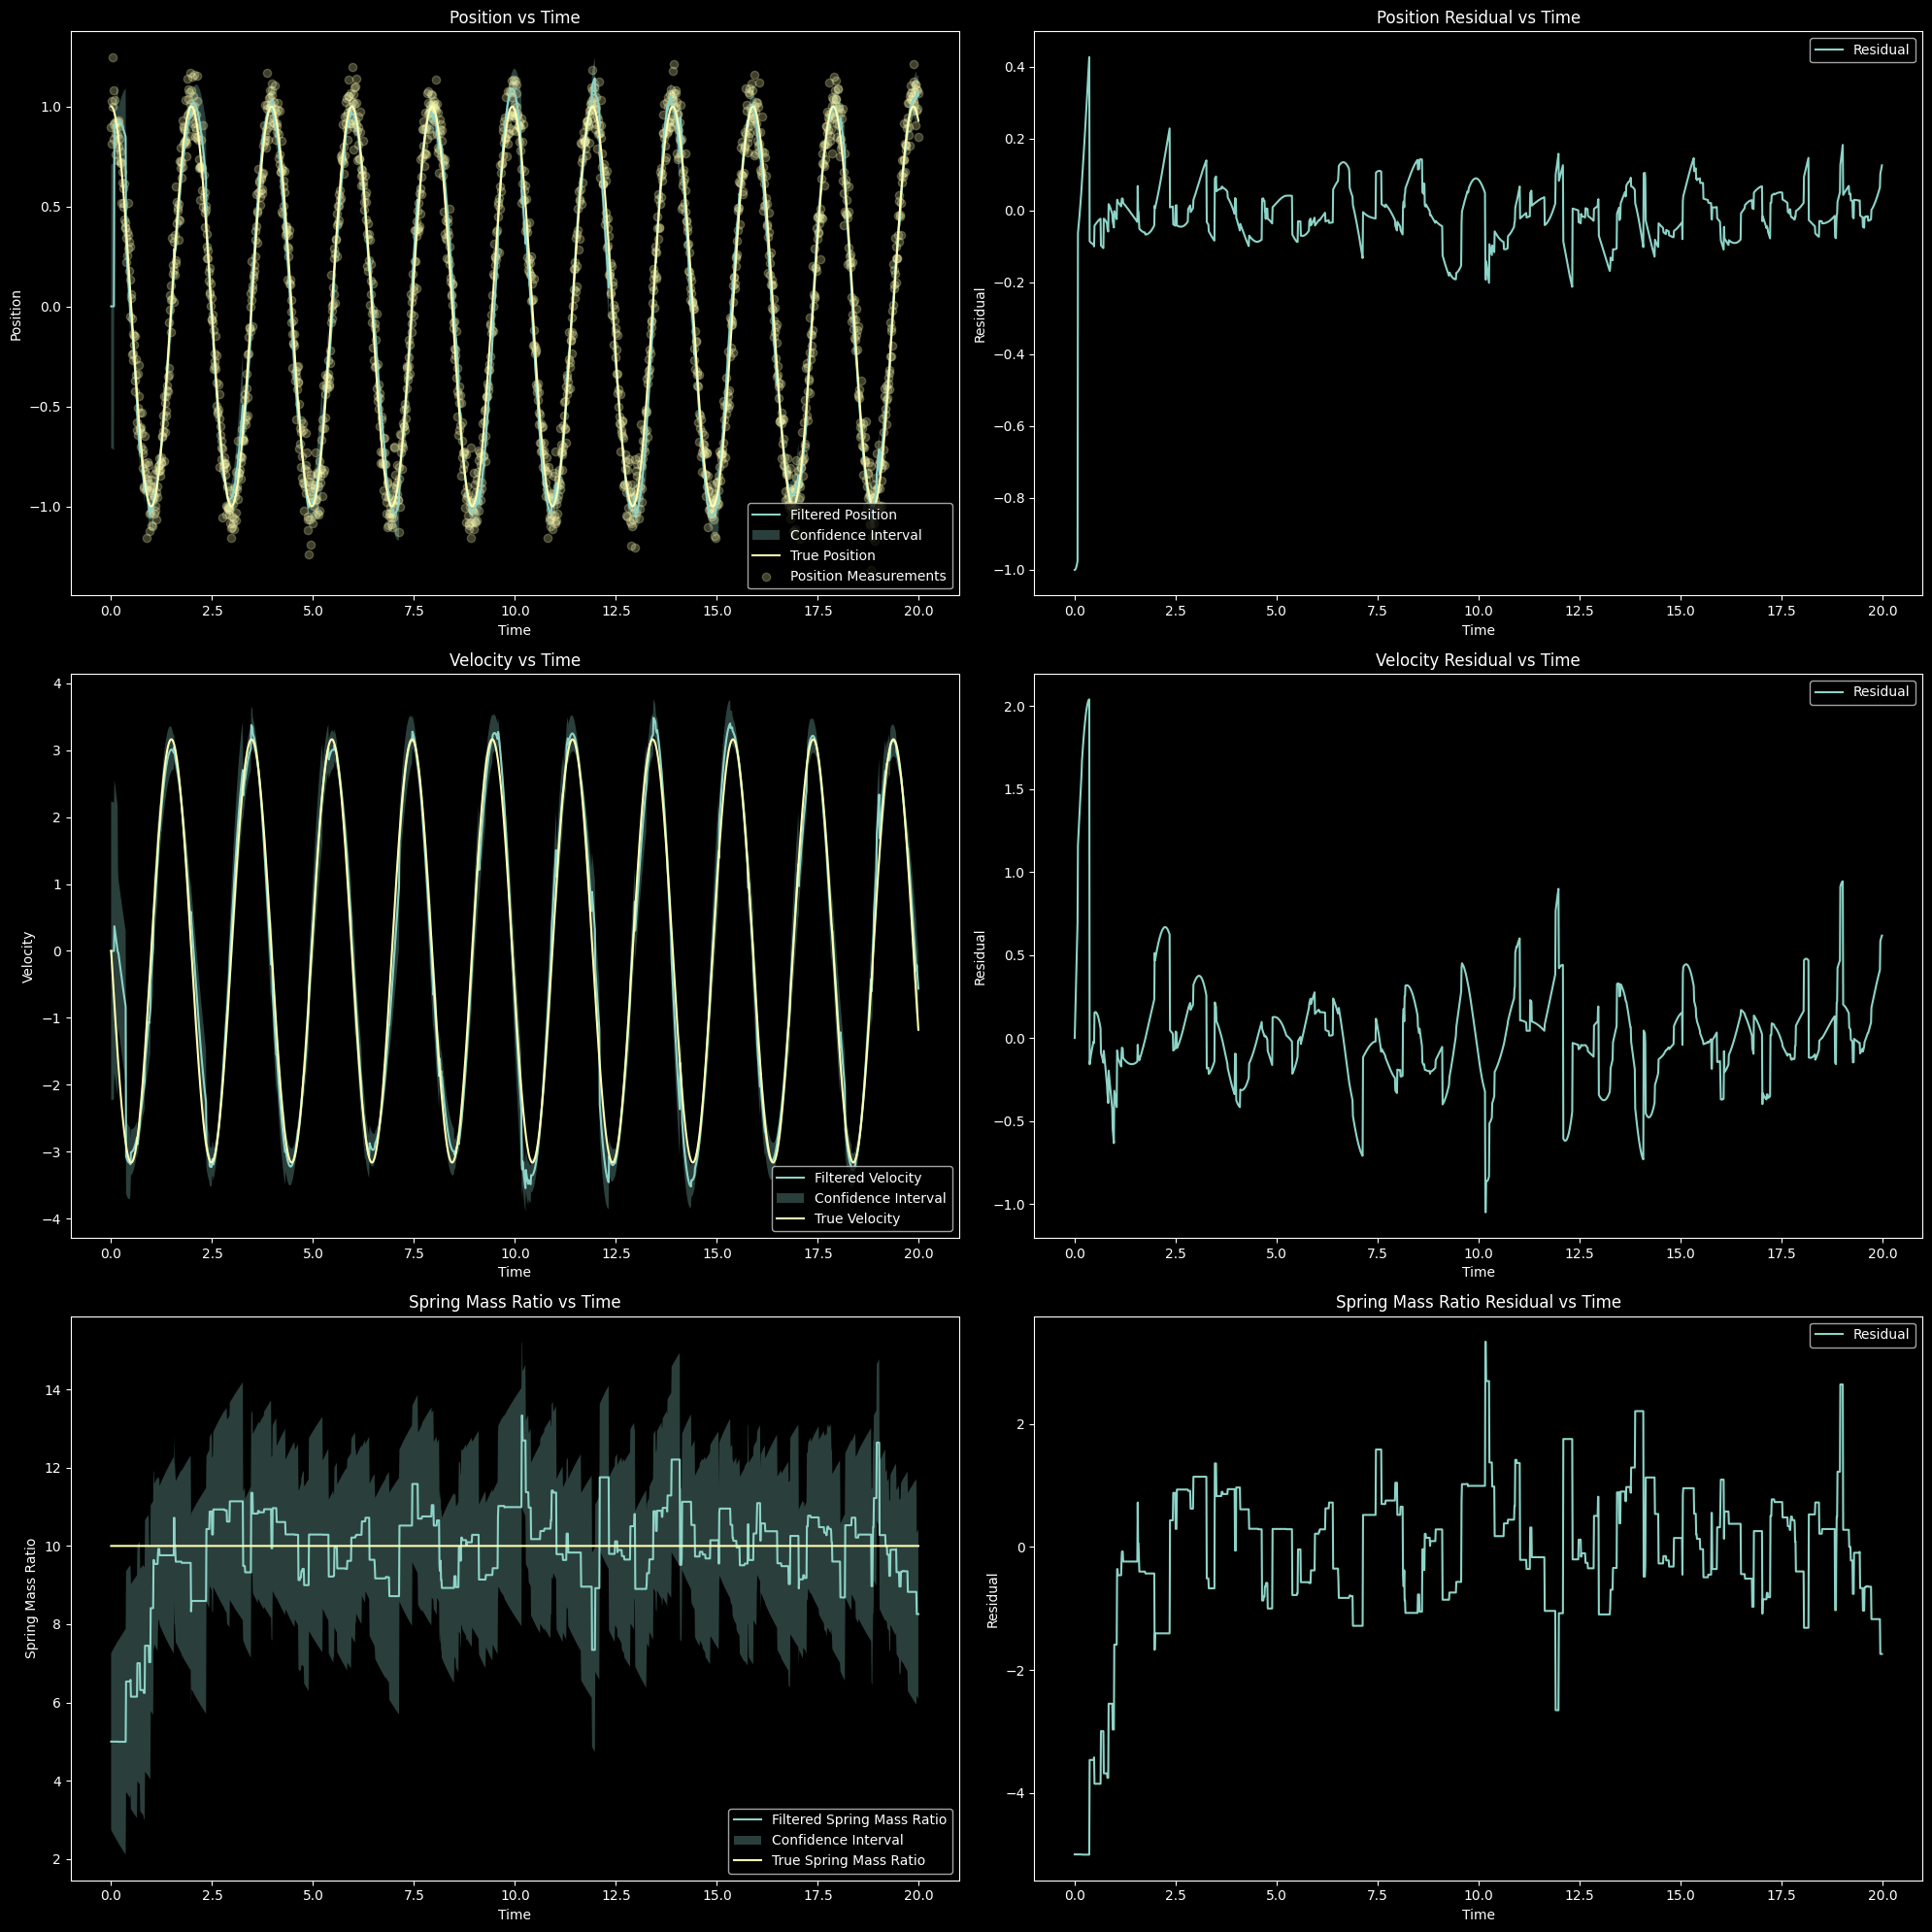

In [13]:
# Plotting position, velocity, acceleration, state variance, and residual over time
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

for ind, label in enumerate(["Position", "Velocity", "Spring Mass Ratio"]):
  # Plotting position vs time
  axs[ind, 0].plot(times, state_history[ind, :], label='Filtered {}'.format(label))
  axs[ind, 0].fill_between(times, state_history[ind, :] - np.sqrt(cov_history[ind, ind, :]),
            state_history[ind, :] + np.sqrt(cov_history[ind, ind, :]),
            alpha=0.3, label='Confidence Interval')
  axs[ind, 0].plot(times, true_states[ind, :], label='True {}'.format(label))
  if ind == 0:
    axs[ind, 0].scatter(times, pos_measurements.T, label='Position Measurements', alpha=0.25)

  axs[ind, 0].set_xlabel('Time')
  axs[ind, 0].set_ylabel(label)
  axs[ind, 0].set_title('{} vs Time'.format(label))
  axs[ind, 0].legend()

  # Plotting residual vs time
  axs[ind, 1].plot(times, state_history[ind, :] - true_states[ind, :], label='Residual')
  axs[ind, 1].set_xlabel('Time')
  axs[ind, 1].set_ylabel('Residual')
  axs[ind, 1].set_title('{} Residual vs Time'.format(label))
  axs[ind, 1].legend()


plt.tight_layout()
plt.show()


In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation


STRIDE = 10

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(cov_history[:, :, 0], cmap='viridis', interpolation='nearest')
fig.colorbar(im, cax=cax, orientation='vertical')  # Add colorbar

def animate(i):
  print("Animating frame {} of {}".format(i, len(times[::STRIDE])), end='\r')
  ax.clear()
  im = ax.imshow(cov_history[:, :, i * STRIDE], cmap='viridis', interpolation='nearest')
  ax.set_title('Covariance Matrix at Time Step {}'.format(i))
  ax.set_xlabel('State Dimension')
  ax.set_ylabel('State Dimension')


ani = animation.FuncAnimation(fig, animate, frames=len(times[::STRIDE]), interval=10, blit=False)
plt.close()
ani
